### <p style="text-align: right;"> &#9989; Andrew Koren</p>

# PHY480 Day 20

## In-class assignment: Ising model in one dimension

In this in-class assignment we implement the Metropolis algorithm for the Ising model in one dimension where the exact solution can also be computed.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


$$
-J \sum_{\langle i,j \rangle} s_i s_j
$$

Often we need our code to be flexible with respect to the dimensionality of the problem, especially for grid-based problems such as the Ising model, defined on a lattice. The physical case is three (for classical statistical systems) or four (for relativistic systems or field theories) dimensions. Sometimes in a lower dimensionality exact solutions are avialable. One possible approach is to map the coordinates of a lattice site to a linear integer index. For instance, consider a two-dimensional $2\times2$ lattice. The coordinates of its sites may be chosen $(0,0)$, $(1,0)$, $(0,1)$ and $(1,1)$. Also we use periodic boundary condtions. Instead of two-dimensional vectors, these sites may be labeled with an integer index taking the values $0$, $1$, $2$ and $3$, in that order. The code below defines a lattice indexer class that, provided the number of dimensions and array with lattice sizes, initializes an object and its nearest neighbor arrays.

In [4]:
# lattice indexer

# class for lattice indexing with support of arbitary dimensionality
# Input:
# number of dimensions
# lattice size array
class lattice:
    
    def __init__( self, num_dim, size ):
        
        self._is_init = False
        if type(num_dim) != int:
            print( "ERROR: lattice class initializaiton: num_dim must be integer.")
            return
        if len( size ) != num_dim:
            print( "ERROR: lattice class initialization: size array does not match num_dim." )
            return
        for i in range( num_dim ):
            if size[i] < 0:
                print( "ERROR: lattice class initialization: size must be positive." )
                return
        
        # initialization flag
        self._is_init = True
        # number of dimensions
        self._num_dim = int( num_dim )
        # lattice size
        self._size = np.array( size, dtype=int )
        # total number of sites (volume)
        self._volume = 1
        for i in range( num_dim ):
            self._volume *= size[i]
        self._volume = int(self._volume)
            
        # forward and backward nearest neighbor index arrays
        # (periodic boundary conditions)
        self._neighbor_forward  = np.zeros( ( self._volume, self._num_dim ), dtype=int )
        self._neighbor_backward = np.zeros( ( self._volume, self._num_dim ), dtype=int )
        for i in range( self._volume ):
            r = self.map_index_to_vec( i )
            for j in range( self._num_dim ):
                
                # forward
                # index to vector
                q = r.copy()
                q[j] += 1
                q[j] %= self._size[j]
                # vector to index
                self._neighbor_forward[i,j] = self.map_vec_to_index( q )

                # backward
                # index to vector
                q = r.copy()
                q[j] += self._size[j] - 1
                q[j] %= self._size[j]
                # vector to index
                self._neighbor_backward[i,j] = self.map_vec_to_index( q )


    # convert site coordinates to linear index
    # Input:
    # r -- coordinate array
    # Output:
    # linear integer site index
    def map_vec_to_index( self, r ):
        
        if self._is_init == False:
            print( "ERROR: attempt to call map_vec_to_index on an unitialized lattice instance.")
            return -1
        if len(r) != self._num_dim:
            print( "ERROR: in map_vec_to_index vector has wrong dimensions:", len(r) )
            return -2
        for i in range(self._num_dim):
            if r[i]<0 or r[i]>=self._size[i]:
                print( "ERROR: in map_vec_to_index vector component", i, "is out of range." )
                return -3
            
        index = 0
        v = 1
        for i in range(self._num_dim):
            index += int(r[i])*v
            v *= self._size[i]
            
        return int(index)
    
    # convert linear site index to site coordinates
    # Input:
    # index -- linear integer site index
    # Output:
    # site coordinate array
    def map_index_to_vec( self, index ):

        if self._is_init == False:
            print( "ERROR: attempt to call map_index_to_vec on an unitialized lattice instance.")
            return -1
        if index < 0 or index >= self._volume:
            print( "ERROR: in map_index_to_vec index is out of range.")
            return -2
            
        v = int(index)
        r = np.zeros( self._num_dim, dtype=int )
        for i in range(self._num_dim):
            r[i] = int( v % self._size[i] )
            v = v // self._size[i]
        
        return r


To help you understand how the lattice indexer works, study the following example.

In [5]:
# define 3x2 lattice
lat = lattice( 2, [3,2] )

# loop over sites (labeled from 0 to 5),
# _volume is class variable that defines the volume = total number of sites
for i in range( lat._volume ):
    
    print( "Site index:", i )
    print( "Coordinates:", lat.map_index_to_vec( i ) )
    print( "Index of the forward  neighbor in x direction:", lat._neighbor_forward[i,0]  )
    print( "Index of the backward neighbor in x direction:", lat._neighbor_backward[i,0] )
    print( "Index of the forward  neighbor in y direction:", lat._neighbor_forward[i,1]  )
    print( "Index of the backward neighbor in y direction:", lat._neighbor_backward[i,1] )
    print()


Site index: 0
Coordinates: [0 0]
Index of the forward  neighbor in x direction: 1
Index of the backward neighbor in x direction: 2
Index of the forward  neighbor in y direction: 3
Index of the backward neighbor in y direction: 3

Site index: 1
Coordinates: [1 0]
Index of the forward  neighbor in x direction: 2
Index of the backward neighbor in x direction: 0
Index of the forward  neighbor in y direction: 4
Index of the backward neighbor in y direction: 4

Site index: 2
Coordinates: [2 0]
Index of the forward  neighbor in x direction: 0
Index of the backward neighbor in x direction: 1
Index of the forward  neighbor in y direction: 5
Index of the backward neighbor in y direction: 5

Site index: 3
Coordinates: [0 1]
Index of the forward  neighbor in x direction: 4
Index of the backward neighbor in x direction: 5
Index of the forward  neighbor in y direction: 0
Index of the backward neighbor in y direction: 0

Site index: 4
Coordinates: [1 1]
Index of the forward  neighbor in x direction: 

This way, all loops over the lattice are one-dimensional and the nearest neighbors can be accessed from the initialized nearest neighbor arrays, for instance, when computing the energy in the Ising model.

**Task 1.** Write two functions which inialize an array of spins in the following way: a) spins are chosen uniformly randomly $+1$ or $-1$ (so-called hot start), b) spins are all set to +1 (cold start).

In [6]:
# initialize spin array randomly
# Input:
# spin -- array of size volume
# volume -- total number of sites on the lattice
# Output:
# no value returned, but the spin array is changed
def make_hot_start( spin_lat, J = 1 ):

    volume = spin_lat._volume
    states = (np.random.rand(volume) < 0.5)*2-1
    spin_lat._states = states
    spin_lat._J = J
    
        
# initialize spin array to 1 for all spins
# Input:
# spin -- array of size volume
# volume -- total number of sites on the lattice
# Output:
# no value returned, but the spin array is changed
def make_cold_start( spin_lat, J = 1 ):


    volume = spin_lat._volume
    states = np.ones(volume, dtype=int)
    spin_lat._states = states
    spin_lat._J = J



**Task 2.** Write a function that computes contribution to the energy for a given value `iq` ($+1$ or $-1$, provided as input) of the spin on site `isite`. Test it on a given hot and cold configuration to make sure it works properly. Test it in one and two dimensions. The `lat` object should be initialized and the `spin` array allocated, i.e. `spin=np.array( lat._volume, dtype=int )`.

**Note:** For the code to work properly you need to ensure that spin values are always integer variables.

In [7]:
# compute local contribution to the energy if the spin on site isite has value iq
# Input:
# lat -- lattice object
# spin -- spin array
# isite -- integer index of the site for which the energy contribution is computed
# iq -- spin value (+1 or -1)
# Output:
# energy, computed as sum of the -J sigma_i sigma_j for the site isite and its nearest neighbors
def compute_energy( spin_lat, isite, iq=None):
    
    J = spin_lat._J

    if iq == None:
        sigma_i = spin_lat._states[isite]
    else:
        sigma_i = iq

    neigbor_indicies = [spin_lat._neighbor_forward[isite,dim] for dim in range(spin_lat._num_dim)] + [spin_lat._neighbor_backward[isite,dim] for dim in range(spin_lat._num_dim)]

    sigma_j = spin_lat._states[neigbor_indicies]
    
    energy = -J*sum(sigma_i*sigma_j)

    return energy


**Task 3.** Write a function that implements the Metropolis algorithm to produce a new value at site `isite`:

- generate a new value `q_new`, +1 or -1 with equal probability (50%),
- compute the energy for the current value of `spin[isite]` and for the proposed value `q_new`,
- compute accept/reject probability,
- accept or reject the move based on a uniform random number,
- if the move is accepted, return `q_new` and `acpt=1`, otherwise return `spin[isite]` (old value) and `acpt=0`.

Test this function by choosing a site on a given spin configuration (hot or cold start) and generating a new value for it.

$$
Z = \sum_s e^{-\beta \epsilon_s} \\
P_s = \frac{e^{-\beta \epsilon_s}}{Z} \\
\frac{P_{1}}{P_{1}+P_{2}} = \frac{\frac{e^{-\beta \epsilon_1}}{Z}}{\frac{e^{-\beta \epsilon_1}}{Z}+\frac{e^{-\beta \epsilon_2}}{Z}} \\
= \frac{1}{1+e^{-\beta(\epsilon_2-\epsilon_1)}} = \frac{1}{1+e^{\beta(\epsilon_1 - \epsilon_2)}}
$$

In [8]:
# generate a new spin value (+1 or -1) with the Metropolis algorithm based on the
# current nearest neighbor environment
# Input:
# lat -- lattice object
# spin -- array with spin values
# isite -- current site for which new spin value is generated
# J -- Ising model coupling
# beta -- inverse temperature
# Output:
# new spin value generated (can be the same as old, if the proposal is rejected)
# acceptance -- =1 if accepted, =0 if rejected
def generate_spin_met( spin_lat, isite, beta ):

    # propose new spin value (uniform)
    q_new = (np.random.rand() < 0.5)*2-1
    
    # save some compute 
    if spin_lat._states[isite] == q_new:
        return q_new, (np.random.rand() < 0.5)*1

    # compute old energy
    Eold = compute_energy(spin_lat, isite)
    
    # compute new energy
    Enew = compute_energy(spin_lat, isite, q_new)

    # accept/reject
    Pnew = 1/(1+np.exp(beta*(Enew-Eold)))
    if Pnew > np.random.rand():
        spin_lat._states[isite] = q_new
        return q_new, 1        
    else:
        return spin_lat._states[isite], 0

**Task 4.** When all spins on the lattice are sequantially updated, this process is often called a "sweep". Write a function that uses the previous function to sequantially update all spins on the lattice with the generated values.


In [9]:
# make one sweep through the lattice, updating each spin with the Metropolis algorithm
# Input:
# lat -- lattice object
# spin -- array with spin values
# J -- Ising model coupling
# beta -- inverse temperature
# Output:
# total sum of accepted moves
def sweep_met( spin_lat, beta ):
    
    new_spin = []
    acceptance_total = 0
    
    for isite in range(spin_lat._volume):
        spin, acceptance = generate_spin_met( spin_lat, isite, beta) # updates during sweep?
        new_spin.append(spin)
        acceptance_total += acceptance

    return acceptance_total


**Task 5.** Implement a function which performs a Monte Carlo simulation. Namely, it performs `Nequi` sweeps for equilibration when no measurements are taken. Then it performs sweeps in a double loop: `Nsim` and `Ninner` where the measurements are taken in the `Nsim` loop only. (This allows us to control the number of measurements, so it does not get too large, for instance, if `Nsim=10` and `Ninner=3`, in total the simulation will perform 30 sweeps through the lattice, however, only every third sweep a measurement is taken, resulting in 10 measurements.) What we are going to measure is the energy density. This can be achieved with the `compute_energy` function written earlier: that function computes the contribution into the total energy for a given site. If we call it for every site, we get twice the total energy (because in such a sum the pairs are double counted). We normalize the energy by dividing that total by 2 and by the total number of _links_ on the lattice (which is equal to the number of sites times the number of dimensions), i.e. we compute the energy density. The `simulate_met` function should measure the energy density at every iteration of the `Nsim` loop and return an array with the energy density values and the acceptance rate.

In [10]:
# make a simulation with Nequi sweeps for equilibration and Nsim x Ninner sweeps,
# measurements are performed once in every Ninner sweeps
# Input:
# lat -- lattice object
# spin -- spin array
# J -- Ising model coupling
# beta -- inverse temperature
# Nequi -- number of sweeps for equilibration
# Nsim -- number of simulation steps in the outer loop, where the measurements are performed
# Ninner -- number of simulations steps (i.e. sweeps) in the inner loop without measurements
# Output:
# array with energy density values of size Nsim
# acceptance rate
def simulate_met( spin_lat, beta, Nequi, Nsim, Ninner ):

    # equilibration
    for i in range(Nequi):
        sweep_met(spin_lat, beta)

        
    # initialize energy array
    energies = []
    acceptance_rates = []
    # main production loop: Nsim
    for _ in range(Nsim):
        total_acceptance = 0
        # inner loop: Ninner
        for _ in range(Ninner):
            # sweep over the lattice
            total_acceptance += sweep_met(spin_lat, beta)

        # compute the energy density
        energy = sum([compute_energy(spin_lat, i) for i in range(spin_lat._volume)])
        e_density = energy/(2*spin_lat._volume)
        acceptance_rate = total_acceptance/(Ninner*spin_lat._volume)

        energies.append(e_density)
        acceptance_rates.append(acceptance_rate)
        
        
    return energies, acceptance_rates

**Task 6.** Implement a function to compute the energy density exactly for one-dimensional Ising model on a chain of $N$ sites with periodic boundary conditions.

In [11]:
# **Task 6.** Implement a function to compute the energy density exactly for one-dimensional Ising model on a chain of $N$ sites with periodic boundary conditions.

# compute exact energy density for 1D Ising model
# Input:
# N -- number of site
# J -- Ising model coupling
# beta -- inverse temperature
# Output:
# energy density

def energy_exact(N, J, beta):
    lambda_plus = np.exp(beta * J) + np.exp(-beta * J)
    lambda_minus = np.exp(beta * J) - np.exp(-beta * J)
    return -J * np.sinh(beta * J) / (np.cosh(beta * J) + (lambda_minus / lambda_plus) ** N)


**Task 7.** Compute the energy density in the Ising model on a one-dimensional lattice of a chosen size up to 8 for several `beta` values given below. Use `Nequi=100`, `Nsim=5000` (or less if too slow), `Ninner=5`. Calculate the mean energy density and its errorbar (i.e. square root of the variance of the mean). Compute the exact energy density at the same `beta` and compare with the Monte Carlo results. Plot the Monte Carlo averages and the exact results. 

In [15]:
from copy import deepcopy

np.random.seed(3)

# initialize lattice
spin_lat = lattice( 1, [4] )

# Ising coupling
J = 0.7 # experiment with changing to check that it is used properly in the functions

# initialize spins
make_hot_start( spin_lat, J=J ) # experiment with cold start

# simulation parameters
Nequi = 100
Nsim = 5000 # try smaller values before you make the code work properly
Ninner = 5

# inverse temperatures
betas = np.linspace(0, 4, 10)

# storage for the mean and errorbar
mean_energies = []
beta_energy_std = []

# loop on beta values
for beta in betas:

    # call simulate function to get the energy density time series
    test_spin_lat = deepcopy(spin_lat)
    energies, a_rates = simulate_met(test_spin_lat, beta, Nequi, Nsim, Ninner)

    # get the mean and errorbar
    mean_energies.append(np.array(energies).mean())
    beta_energy_std.append(np.array(energies).std())



Text(0, 0.5, 'Mean energy $\\mu$')

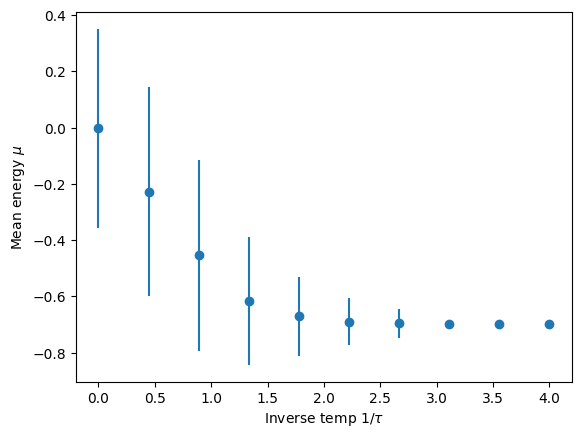

In [16]:
plt.errorbar(betas, mean_energies, yerr=beta_energy_std, fmt='o')
plt.xlabel(r'Inverse temp $1/\tau$')
plt.ylabel(r'Mean energy $\mu$')

&#169; Copyright 2025,  Michigan State University Board of Trustees